In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Eye Disease Detection**

**Steps taken to solve problem**
* Step 1: Import common libraries
* Step 2: Setup GPU
* Step 3: Getting the data
* Step 4: Build/Train a CNN
* Step 5: Fit the data
* Step 6: Improve the model
* Step 7: Fit improved model
* Step 8: Save the model
* Step 9: Presenting results visually


## **Global variables/Hyperparameters**

---



In [77]:
Image_height = 196
Image_width = 300
val_split = 0.2
batches_size = 10
lr = 0.0001
spe = 512
vs = 32
epoch = 10

## **Step 1: Import common libraries**

---



In [62]:
#Common machine learning libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
#Used for setting up GPU and image classifcation
import tensorflow as tf
import tensorflow_hub as hub 

#Used for seeing how many images we have within each folder
import os

#Used for split / viewing images later on
import glob

#Libraries needed for image classification
from tensorflow import keras 
from keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Activation, Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization, UpSampling2D, Lambda
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications import imagenet_utils


## **Step 2: Setup GPU**

---



In [4]:
print("GPU is working" if tf.config.list_physical_devices("GPU") else " GPU is not working. Please change the runtime to use GPU")

GPU is working


## **Step 3: Getting Data**

---



In [5]:
# Getting the file of the training set and testing set
train_folder = "/content/drive/My Drive/Research/train"
test_folder = "/content/drive/My Drive/Research/test"

In [6]:
#Code to iterate over all the files (Sub directories included). This will be used to see how many training and images we have
CNV_train = os.listdir("/content/drive/My Drive/Research/train/CNV")
DME_train = os.listdir("/content/drive/My Drive/Research/train/DME")
DRUSEN_train = os.listdir("/content/drive/My Drive/Research/train/DRUSEN")
NORMAL_train = os.listdir("/content/drive/My Drive/Research/train/NORMAL")

CNV_test = os.listdir("/content/drive/My Drive/Research/test/CNV") 
DME_test = os.listdir("/content/drive/My Drive/Research/test/DME")
DRUSEN_test = os.listdir("/content/drive/My Drive/Research/test/DRUSEN")
NORMAL_test = os.listdir("/content/drive/My Drive/Research/test/NORMAL")

total_training = len(CNV_train + DME_train + DRUSEN_train + NORMAL_train)
total_testing = len(CNV_test + DME_test + DRUSEN_test + NORMAL_test)

print("We have",total_training, "total images in the training folder and", total_testing, "images in the testing folder")
print(f"Allocating {(1-val_split)*100}% for training {val_split*100}% for validation on the training set we get:")
print(total_training*(1-val_split), "images for training")
print(total_training*(val_split), "images for validation")

We have 83484 total images in the training folder and 1000 images in the testing folder
Allocating 80.0% for training 20.0% for validation on the training set we get:
66787.2 images for training
16696.8 images for validation


In [72]:
#Creating batches
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=val_split) \
    .flow_from_directory(directory=train_folder, target_size=(Image_height,Image_width), classes=['CNV','DME','DRUSEN','NORMAL'], batch_size=batches_size,class_mode="categorical",
                              subset="training")
validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,validation_split=val_split) \
    .flow_from_directory(directory=train_folder, target_size=(Image_height,Image_width), classes=['CNV','DME','DRUSEN','NORMAL'], batch_size=batches_size,class_mode="categorical",
                              subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                       .flow_from_directory(test_folder, target_size=(Image_height,Image_width), 
                         classes=['CNV','DME','DRUSEN','NORMAL'], batch_size=batches_size,class_mode="categorical")

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


## **Step 4: Build/Train a CNN**

---



In [8]:
#building the model to train a CNN. This will be used to extract features of images
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(Image_height,Image_width,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=4, activation='softmax')
])

In [9]:
#Checking the models summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 194, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 97, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 95, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 47, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 219584)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 878340    
Total params: 897,732
Trainable params: 897,732
Non-trainable params: 0
__________________________________________________

## **Step 5: Fit the data**
---




In [106]:
#Compiling the model
model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [110]:
#Fitting the data
model.fit(train_batches, steps_per_epoch = spe, epochs = epoch, 
            validation_data = vs, validation_steps = vs,shuffle = True)

Epoch 1/10
128/128 [==============================] - 1893s 15s/step - loss: 6.1900 - accuracy: 0.4561 - val_loss: 3.1588 - val_accuracy: 0.4326
Epoch 2/10
128/128 [==============================] - 1604s 13s/step - loss: 1.9485 - accuracy: 0.5793 - val_loss: 1.3147 - val_accuracy: 0.6201
Epoch 3/10
128/128 [==============================] - 1464s 11s/step - loss: 1.0720 - accuracy: 0.6740 - val_loss: 1.1694 - val_accuracy: 0.6445
Epoch 4/10
128/128 [==============================] - 1444s 11s/step - loss: 0.9682 - accuracy: 0.6892 - val_loss: 0.9238 - val_accuracy: 0.6865
Epoch 5/10
128/128 [==============================] - 1289s 10s/step - loss: 0.7701 - accuracy: 0.7217 - val_loss: 0.8793 - val_accuracy: 0.7012
Epoch 6/10
128/128 [==============================] - 1331s 10s/step - loss: 0.6729 - accuracy: 0.7637 - val_loss: 0.7865 - val_accuracy: 0.7178
Epoch 7/10
128/128 [==============================] - 1155s 9s/step - loss: 0.6316 - accuracy: 0.7793 - val_loss: 0.7348 - val_acc

## **Step 6: Improve the model**

---


In [13]:
#Function to create model. We will be using a pretrained model
def create():
  vgg16_model = keras.applications.vgg16.VGG16(input_tensor=Input(shape=(Image_height, Image_width, 3)),input_shape=(Image_height,Image_width,3), include_top = False)
  model = Sequential()
  model.add(vgg16_model)
  for layer in model.layers:
    layer.trainable = False
  model.add(Flatten())
  model.add(Dense(4, activation='softmax'))
  return model

## **Step 7: Fit improved model**

---



In [67]:
model = create()
model.compile(Adam(lr=lr),loss="categorical_crossentropy",metrics=['accuracy'])

In [ ]:
model.fit(train_batches, steps_per_epoch=spe,
                    validation_data=validation_batches_10,validation_steps=vs, epochs=epoch)

## **Step 8: Save the model**

---



In [25]:
model.save("VGG16_model.h5")

## **Step 9: Presenting results visually**

---




In [26]:
#Load model if needed
model = keras.models.load_model('/content/VGG16_model.h5')

In [32]:
def plotImages(images_arr):
  fig,ax = plt.subplots(1,10,figsize=(20,20))
  ax=ax.flatten()
  for img, ax in zip(images_arr,ax):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

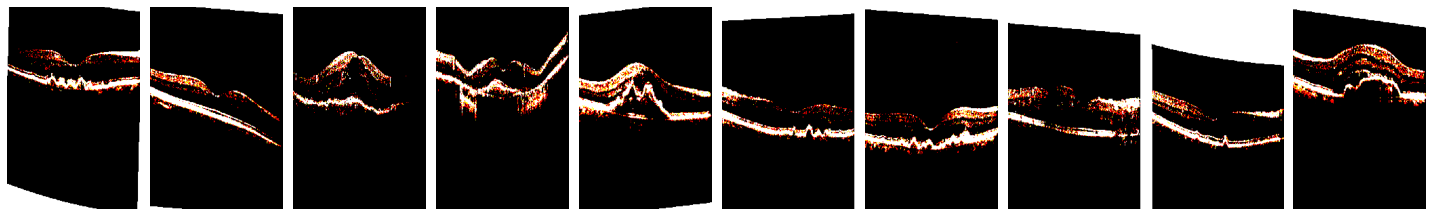

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [42]:
test_imgs, test_labels = next(test_batches_10)
plotImages(test_imgs)
print(test_labels)

In [44]:
test_batches_10.classes[0:1000:100]

array([0, 0, 0, 1, 1, 2, 2, 2, 3, 3], dtype=int32)

In [45]:
predictions = model.predict(x=test_batches_10,verbose=0)

In [46]:
np.round(predictions)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [51]:
cm = confusion_matrix(y_true=test_batches_10.classes, y_pred=np.argmax(predictions,axis=-1))

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
test_batches_10.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Confusion matrix, without normalization
[[82 43 55 70]
 [96 44 43 67]
 [93 43 47 67]
 [96 41 49 64]]


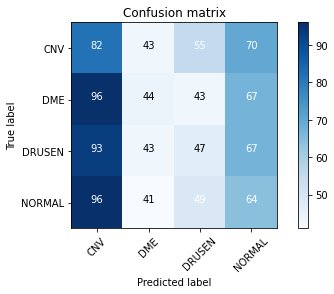

In [61]:
cm_plot_labels = ['CNV','DME','DRUSEN','NORMAL']
plot_confusion_matrix(cm,cm_plot_labels,title="Confusion matrix")

# Xception Model

In [73]:
def create():
  xception_model = tf.keras.applications.Xception(input_tensor=Input(shape=(Image_height, Image_width, 3)),input_shape=(Image_height,Image_width,3), include_top = False)
  model = Sequential()
  model.add(xception_model)
  for layer in model.layers:
    layer.trainable = False
  model.add(Flatten())
  model.add(Dense(4, activation='softmax'))
  return model

In [74]:
model = create()
model.compile(Adam(lr=lr),loss="categorical_crossentropy",metrics=['accuracy'])

83689472/83683744 [==============================] - 2s 0us/step


In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 6, 10, 2048)       20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 491524    
Total params: 21,353,004
Trainable params: 491,524
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
model.fit(train_batches, steps_per_epoch=spe,
                    validation_data=validation_batches,validation_steps=vs, epochs=epoch)

Epoch 1/10
512/512 [==============================] - 5606s 11s/step - loss: 7.4320 - accuracy: 0.5426 - val_loss: 8.0523 - val_accuracy: 0.4859
Epoch 2/10
512/512 [==============================] - 5079s 10s/step - loss: 6.7518 - accuracy: 0.5625 - val_loss: 7.8662 - val_accuracy: 0.6047
Epoch 3/10
512/512 [==============================] - 4459s 9s/step - loss: 7.1621 - accuracy: 0.5709 - val_loss: 8.9813 - val_accuracy: 0.5594
Epoch 4/10
512/512 [==============================] - 4002s 8s/step - loss: 7.1249 - accuracy: 0.5852 - val_loss: 10.5663 - val_accuracy: 0.5512
Epoch 5/10
512/512 [==============================] - 3659s 7s/step - loss: 7.0733 - accuracy: 0.5764 - val_loss: 8.5909 - val_accuracy: 0.5840
Epoch 6/10
512/512 [==============================] - ETA: 0s - loss: 6.5823 - accuracy: 0.6037